# Feature Engineering

In machine learning, a feature is an individual measurable attribute of a phenomenon being observed. The extraction of features from raw training data is called *feature engineering*. In other words, feature engineering is a process of transforming raw training data into a *representation* suitable for the application of machine learning algorithms.

This process usually requires a certain degree of domain expertise and can be divided into the following stages <sup>[[1]](#ref_1)</sup>: 
- Brainstorming on features
- Deciding what features to create
- Creating features
- Studying how the features impact model's predictive accuracy
- Iterating if necessary

In [1]:
%matplotlib inline
import os
import json
import pickle
import pyspark
from functools import reduce
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.functions import udf, mean, lit, stddev, col, expr, when, date_sub
from pyspark.sql.types import DoubleType, ArrayType, ShortType, LongType, IntegerType, TimestampType, StructType, StringType, StructField
import pandas as pd
from collections import OrderedDict
from datetime import date
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from pyspark.storagelevel import StorageLevel

from azureml.api.schema.dataTypes import DataTypes
from azureml.api.schema.sampleDefinition import SampleDefinition
from azureml.api.realtime.services import generate_schema

STORAGE_ACCOUNT_SUFFIX = 'core.windows.net'

TELEMETRY_STORAGE_ACCOUNT_NAME = os.getenv('TELEMETRY_STORAGE_ACCOUNT_NAME')
TELEMETRY_STORAGE_ACCOUNT_KEY = os.getenv('TELEMETRY_STORAGE_ACCOUNT_KEY')
TELEMETRY_CONTAINER_NAME = os.getenv('TELEMETRY_CONTAINER_NAME')
LOGS_ARCHIVE_CONTAINER_NAME = 'logs-archive' #TODO: introduce environment variables
STAGING_STORAGE_ACCOUNT_NAME = os.getenv('STAGING_STORAGE_ACCOUNT_NAME')
STAGING_STORAGE_ACCOUNT_KEY = os.getenv('STAGING_STORAGE_ACCOUNT_KEY')
AZUREML_NATIVE_SHARE_DIRECTORY = os.getenv('AZUREML_NATIVE_SHARE_DIRECTORY') + 'Pdm_Solution1'

##  Reading raw training data

### Telemetry data
First, let's read the raw telemetry dataset from Azure Blob storage into a Spark dataframe. This dataset consists of IoT Hub messages that contain sensor readings<sup>[[2]](#ref_2)</sup>. Captured data is written in Apache Avro format: a compact, fast, binary format that provides rich data structures with inline schema<sup>[[3]](#ref_3)</sup>.

In [2]:
wasbTelemetryUrl = "wasb://{0}@{1}.blob.{2}/*/*/*/*/*/*/*".format(
            TELEMETRY_CONTAINER_NAME,
            TELEMETRY_STORAGE_ACCOUNT_NAME,
            STORAGE_ACCOUNT_SUFFIX)

sc = SparkSession.builder.getOrCreate()
hc = sc._jsc.hadoopConfiguration()
hc.set("avro.mapred.ignore.inputs.without.extension", "false")

if TELEMETRY_STORAGE_ACCOUNT_KEY:
    hc.set("fs.azure.account.key.{}.blob.core.windows.net"
           .format(TELEMETRY_STORAGE_ACCOUNT_NAME), TELEMETRY_STORAGE_ACCOUNT_KEY)

hc.set("fs.azure.account.key.{}.blob.core.windows.net"
       .format(STAGING_STORAGE_ACCOUNT_NAME), STAGING_STORAGE_ACCOUNT_KEY)
    
sql = SQLContext.getOrCreate(sc)

telemetry_df = sql.read.format("com.databricks.spark.avro").load(wasbTelemetryUrl)

telemetry_df.printSchema()

root
 |-- EnqueuedTimeUtc: string (nullable = true)
 |-- Properties: map (nullable = true)
 |    |-- key: string
 |    |-- value: string (valueContainsNull = true)
 |-- SystemProperties: map (nullable = true)
 |    |-- key: string
 |    |-- value: string (valueContainsNull = true)
 |-- Body: binary (nullable = true)



### Event logs

Our second input dataset contains event logs in CSV format. The assumption we make here is that some events may be automatically triggered by monitoring equipment, and some may be created as a result of human intervension, such as an inspection or maintenance. These are the columns present in the event logs:

- timestamp
- level (INFO, WARNING, ERROR, CRITICAL)
- machine ID
- code (identifies event type)
- message (contains additional details)

Sometimes event logs themselves serve as the primary input for training a predictive model<sup>[[4]](#ref_4)</sup>. In our case, the logs don't feature rich and sizeable data. Yet, they will play a crucial role in helping us assign classes to the feature vectors (or, in other words, label our training dataset).

In [3]:
wasbTelemetryUrl = "wasb://{0}@{1}.blob.{2}/*.log".format(
            LOGS_ARCHIVE_CONTAINER_NAME,
            TELEMETRY_STORAGE_ACCOUNT_NAME,
            STORAGE_ACCOUNT_SUFFIX)

logs_df = sql.read.csv(wasbTelemetryUrl, header=False)

logs_df = logs_df.select(
    col('_c0').cast(TimestampType()).alias('timestamp'),
    col('_c1').alias('level'),
    col('_c2').alias('machineID'),
    col('_c3').alias('code'),
    col('_c4').alias('message')
)

logs_df.printSchema()

root
 |-- timestamp: timestamp (nullable = true)
 |-- level: string (nullable = true)
 |-- machineID: string (nullable = true)
 |-- code: string (nullable = true)
 |-- message: string (nullable = true)



In [4]:
print('Telemetry message count: {0}'.format(telemetry_df.count()))
print('Event log entry count: {0}'.format(logs_df.count()))

Telemetry message count: 202649
Event log entry count: 22


## Reconstructing telemetry from the binary payload
The Body column in the telemetry dataframe above is a pickled Python object which encapsulates multiple sensor readings at a given time. Among these readings are:
- ambient temperature (°C)
- ambient pressure (kPa)
- rotational speed (RPM)
- temperature (°C)
- pressure (kPa)
- vibration signal (16 bit integer PCM data at 1024 Hz)

The last 4 values describe the state of a machine, whereas the first two describe the operational environment.
Below, we are performing the following:
- extracting the machine ID from IoT Hub message's *SystemProperties*
- converting IoT Hub's *EnqueuedTimeUtc* into Spark's native TimestampType
- restoring the 6 sensor readings from the binary payload (and adding them as columns to the dataframe)
- removing unused IoT Hub message metadata

In [5]:
input_columns = [
    ("ambient_temperature", DoubleType()),
    ("ambient_pressure", DoubleType()),
    ("speed", DoubleType()),
    ("temperature", DoubleType()),
    ("pressure", DoubleType()),
    ("vibration", ArrayType(ShortType()))]

def extract_value(c):
    """Returns a PySpark UDF that un-pickles
    the payload, then extracts a value by its key
    performing a type conversion if needed.
    """
    def f(x):
        v = pickle.loads(x)[c[0]]
        if isinstance(v, np.ndarray):
            v = v.tolist()
        if isinstance(c[1], DoubleType):            
            v = float(v)
        return v
    return udf(f, c[1])

telemetry_df = (telemetry_df
      .withColumn('machineID', telemetry_df.SystemProperties['connectionDeviceId'])
      .withColumn("timestamp", telemetry_df['EnqueuedTimeUtc'].cast(TimestampType())))

# Note: The reduce function provides a concise way of adding many columns to the dataframe at once.
# We will be using this pattern a couple of times throughout this notebook.
telemetry_df = (reduce(lambda _df, ic: _df.withColumn(ic[0], extract_value(ic)(telemetry_df.Body)), input_columns, telemetry_df)
      .drop('Properties', 'SystemProperties', 'Body', 'EnqueuedTimeUtc'))

telemetry_df.printSchema()

root
 |-- machineID: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- ambient_temperature: double (nullable = true)
 |-- ambient_pressure: double (nullable = true)
 |-- speed: double (nullable = true)
 |-- temperature: double (nullable = true)
 |-- pressure: double (nullable = true)
 |-- vibration: array (nullable = true)
 |    |-- element: short (containsNull = true)



## Digression: Input sample and service schema
Before we proceed and transform the input dataset into features, let's take advantage of having access to the actual input telemetry and take a sample. That way, when performing model operationalization, it won't be necessary to read and reconstruct the raw dataset once again.

As mentioned earlier, there are 6 sensor readings coming from each machine. The same sensor readings will be sent to a real-time Web service to get failure predictions from the model.

In [6]:
input_sample = telemetry_df.limit(5).select([ic[0] for ic in input_columns])  # select only sensor readings into the sample;
                                                                    # no machineID, timestamp, etc

# define the input data frame
inputs = {"input_df": SampleDefinition(DataTypes.SPARK, input_sample)}

# dummy run function
def run(input_df):
    pass

json_schema = generate_schema(run_func=run,
                              inputs=inputs,
                              filepath=os.path.join(AZUREML_NATIVE_SHARE_DIRECTORY,'service_schema.json'))

We will need *service_schema.json* when the model is ready to be operationalized. For now, let's leave it at that.

## Data exploration

### Frequency-domain graph of a single vibration signal sample

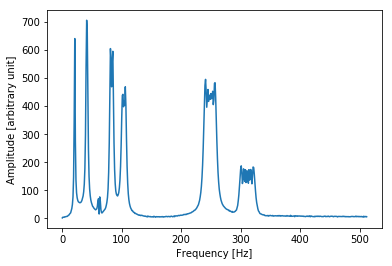

In [7]:
vibration = np.array(telemetry_df.where(telemetry_df.speed > 1000).first().vibration)
sample_rate = 1024

ampl = np.abs(np.fft.fft(vibration)) / sample_rate
dft = ampl[:sample_rate // 2 + 1].tolist()

plt.plot(dft)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [arbitrary unit]')
plt.show()

### Spectrogram of vibration signal over time

This shows how signal's frequencies vary with time as a machine operates at different speeds.

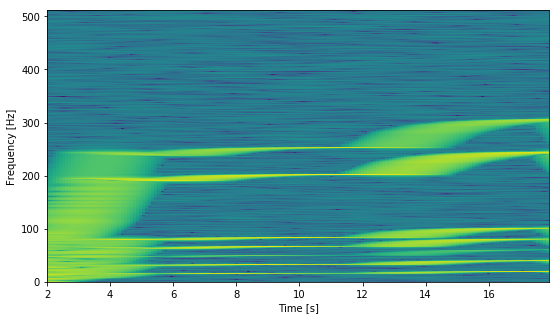

In [8]:
k = telemetry_df.where(telemetry_df.machineID == 'MACHINE-000').orderBy('EnqueuedTimeUtc').take(20)
k = np.concatenate(np.array([x.vibration for x in k]))

freqs, times, Sx = signal.spectrogram(k, fs=sample_rate, window='hanning',
                                      nperseg=4096, noverlap=4096 - 100,
                                      detrend=False, scaling='spectrum')
f, ax = plt.subplots(figsize=(9, 5))
ax.pcolormesh(times, freqs, 10 * np.log10(Sx), cmap='viridis')
ax.set_ylabel('Frequency [Hz]')
ax.set_xlabel('Time [s]')
plt.show()

### Extracting dominant frequencies from a discrete Fourier transform (DFT)

In [9]:
freq = np.fft.fftfreq(sample_rate, d = 1/sample_rate)[:sample_rate // 2 + 1]
max_freq = sorted(list(zip(freq, dft)), key = lambda x: x[1], reverse = True)[10 : ]
pdf = pd.DataFrame.from_records(max_freq)
pdf.head()

,0,1
0,256.0,481.195621
1,240.0,474.285027
2,106.0,469.026084
3,83.0,468.944965
4,245.0,459.419655


## Feature extraction

Here, we combine some of the featurization ideas explored earlier into a reusable Python module. Making the featurizer reusable eliminates the need of duplicating its code elsewhere. In this case, we will be consuming this module from the real-time scoring Web service to perform exactly the same transformation on the input dataframe.

In a nutshell, the *featurize* function below transforms its input by doing the following:

- performing a fast Fourier transform (FFT) of the vibration signal to obtain its amplitude spectrum up to the *Nyquist frequency* (i.e., half the sampling frequency)<sup>[[5]](#ref_5)</sup>
- extracting *N* dominant frequencies  from the DFT (the output of the FFT)
- producing an additional set of normalized features from the ones which are believed to be linearly correlated with the *speed* by means of simple division

In [10]:
%%writefile $AZUREML_NATIVE_SHARE_DIRECTORY/featurization.py

import numpy as np
from pyspark.sql.types import DoubleType, ArrayType, ShortType, LongType, IntegerType
from functools import reduce
from pyspark.ml.feature import StringIndexer, VectorAssembler, VectorIndexer
from pyspark.sql.functions import udf, col
from pyspark.storagelevel import StorageLevel

def featurize(input_df, persist = False):
    sample_rate = 1024
    
    def extract_amplitude_spectrum(x):
        ampl = np.abs(np.fft.fft(x)) / sample_rate
        return ampl[:sample_rate // 2 + 1].tolist()

    extract_amplitude_spectrum_udf = udf(extract_amplitude_spectrum, ArrayType(DoubleType()))

    def extract_dominant_frequencies(index):
        def m(ff):
            freq = np.fft.fftfreq(sample_rate, d = 1/sample_rate)[:sample_rate // 2 + 1]
            return [float(f[index]) for f in sorted(list(zip(freq, ff)), key = lambda x: x[1], reverse = True)]

        return udf(m, ArrayType(DoubleType()))

    features_df = input_df.withColumn("fft", extract_amplitude_spectrum_udf(input_df.vibration))

    features_df = (features_df
           .withColumn("dominant_frequencies", extract_dominant_frequencies(0)(features_df.fft))
           .withColumn("dominant_frequencies_amplitudes", extract_dominant_frequencies(1)(features_df.fft))
           .where(features_df.speed > 0))

    frequency_features = 3
    features_df = reduce(lambda _df, i: _df.withColumn('f{0}'.format(i), _df.dominant_frequencies[i]), range(frequency_features), features_df)
    features_df = reduce(lambda _df, i: _df.withColumn('a{0}'.format(i), _df.dominant_frequencies_amplitudes[i]), range(frequency_features), features_df)
        
    features_df = features_df.drop('vibration', 'fft', 'dominant_frequencies', 'dominant_frequencies_amplitudes')
    
    if persist:
        features_df.persist(StorageLevel.MEMORY_AND_DISK)

    dependent_features = [c for c in features_df.columns if c not in ['machineID', 'timestamp', 'speed', 'ambient_pressure', 'ambient_temperature']]
    features_df = reduce(lambda _df, f: _df.withColumn('{0}_n'.format(f), col(f) / col('speed')), dependent_features, features_df)
    
    return features_df

Overwriting /mnt/azureml-share/featurization.py


In [11]:
%run $AZUREML_NATIVE_SHARE_DIRECTORY/featurization.py

In [12]:
features_df = featurize(telemetry_df, True)
features_df.printSchema()

root
 |-- machineID: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- ambient_temperature: double (nullable = true)
 |-- ambient_pressure: double (nullable = true)
 |-- speed: double (nullable = true)
 |-- temperature: double (nullable = true)
 |-- pressure: double (nullable = true)
 |-- f0: double (nullable = true)
 |-- f1: double (nullable = true)
 |-- f2: double (nullable = true)
 |-- a0: double (nullable = true)
 |-- a1: double (nullable = true)
 |-- a2: double (nullable = true)
 |-- temperature_n: double (nullable = true)
 |-- pressure_n: double (nullable = true)
 |-- f0_n: double (nullable = true)
 |-- f1_n: double (nullable = true)
 |-- f2_n: double (nullable = true)
 |-- a0_n: double (nullable = true)
 |-- a1_n: double (nullable = true)
 |-- a2_n: double (nullable = true)



### Label assignment

In [13]:
failures_df = logs_df.where(col('level') == 'CRITICAL')
failures_df.toPandas().head()

,timestamp,level,machineID,code,message
0,2018-04-22 23:25:01.580444,CRITICAL,MACHINE-008,F02,low pressure - cooling system malfunction
1,2018-04-22 23:39:01.329993,CRITICAL,MACHINE-009,F01,rotor imbalance - defective bearings


In [14]:
failure_intervals_df = (failures_df.select(col('machineID'),
                                           (col('timestamp') - expr("INTERVAL 1 DAYS")).alias('onset_ts'),
                                           col('timestamp').alias('detection_ts'),
                                           col('code').alias('failure')))
failure_intervals_df.toPandas().head()

,machineID,onset_ts,detection_ts,failure
0,MACHINE-008,2018-04-21 23:25:01.580444,2018-04-22 23:25:01.580444,F02
1,MACHINE-009,2018-04-21 23:39:01.329993,2018-04-22 23:39:01.329993,F01


In [15]:
labeled_features_df = (features_df.join(failure_intervals_df,
                                       (features_df.machineID == failure_intervals_df.machineID) &
                                       (features_df.timestamp >= failure_intervals_df.onset_ts) &
                                       (features_df.timestamp <= failure_intervals_df.detection_ts),
                                       'left_outer')
                       .drop(failure_intervals_df.machineID)
                       .drop(failure_intervals_df.onset_ts)
                       .drop(failure_intervals_df.detection_ts)
                       .fillna({'failure':'None'}))
                                                          
labeled_features_df.printSchema()

root
 |-- machineID: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- ambient_temperature: double (nullable = true)
 |-- ambient_pressure: double (nullable = true)
 |-- speed: double (nullable = true)
 |-- temperature: double (nullable = true)
 |-- pressure: double (nullable = true)
 |-- f0: double (nullable = true)
 |-- f1: double (nullable = true)
 |-- f2: double (nullable = true)
 |-- a0: double (nullable = true)
 |-- a1: double (nullable = true)
 |-- a2: double (nullable = true)
 |-- temperature_n: double (nullable = true)
 |-- pressure_n: double (nullable = true)
 |-- f0_n: double (nullable = true)
 |-- f1_n: double (nullable = true)
 |-- f2_n: double (nullable = true)
 |-- a0_n: double (nullable = true)
 |-- a1_n: double (nullable = true)
 |-- a2_n: double (nullable = true)
 |-- failure: string (nullable = false)



### Persisting the labeled feature dataset

Now, let's write the feature dataset into Azure storage. This step, depending on the size of the raw input data and available compute power, may take some time. Spark favors lazy evaluation, which means that all the transformations we have performed so far didn't actually take place. The code below will force Spark to evaluate the entire dataset.

In [16]:
wasbUrlOutput = "wasb://{0}@{1}.blob.{2}/features.parquet".format(
            'intermediate',
            STAGING_STORAGE_ACCOUNT_NAME,
            STORAGE_ACCOUNT_SUFFIX)

labeled_features_df.write.parquet(wasbUrlOutput, mode="overwrite")

labeled_features_df.limit(5).toPandas().head()

,machineID,timestamp,ambient_temperature,ambient_pressure,speed,temperature,pressure,f0,f1,f2,...,a2,temperature_n,pressure_n,f0_n,f1_n,f2_n,a0_n,a1_n,a2_n,failure
0,MACHINE-003,2018-04-22 11:55:10.893,20.0,101.0,1182.50,36.52,2532.72,41.0,42.0,21.0,...,640.926509,0.030884,2.141835,0.034672,0.035518,0.017759,0.597216,0.561192,0.542010,None
1,MACHINE-008,2018-04-22 11:55:11.268,20.0,101.0,790.93,69.35,1660.08,28.0,14.0,57.0,...,742.430154,0.087682,2.098896,0.035401,0.017701,0.072067,1.228768,0.964377,0.938680,F02
2,MACHINE-003,2018-04-22 11:55:11.409,20.0,101.0,765.23,68.58,2033.57,27.0,53.0,54.0,...,705.341621,0.089620,2.657462,0.035284,0.069260,0.070567,1.250674,0.956572,0.921738,None
3,MACHINE-009,2018-04-22 11:55:11.456,20.0,101.0,1029.32,66.92,2419.77,36.0,37.0,35.0,...,5187.308005,0.065014,2.350843,0.034975,0.035946,0.034003,6.383699,5.847304,5.039548,F01
4,MACHINE-001,2018-04-22 11:55:11.471,20.0,101.0,756.15,67.75,1864.12,26.0,155.0,153.0,...,964.530241,0.089599,2.465278,0.034385,0.204986,0.202341,1.477247,1.282516,1.275581,None


## References
<a name="ref_1"></a>1.  [Big Data: Week 3 Video 3 - Feature Engineering](https://www.youtube.com/watch?v=drUToKxEAUA). youtube.com.

<a name="ref_2"></a>2.  [Save IoT hub messages that contain sensor data to your Azure blob storage](https://docs.microsoft.com/en-us/azure/iot-hub/iot-hub-store-data-in-azure-table-storage)

<a name="ref_3"></a>3.  [Azure Event Hubs Capture](https://docs.microsoft.com/en-us/azure/event-hubs/event-hubs-capture-overview)

<a name="ref_4"></a>4.  [Log-based Predictive Maintenance](https://astro.temple.edu/~tua63862/indg0371-sipos.pdf)

<a name="ref_5"></a>5.  [Digital Signal Processing Using MATLAB for Students and Researchers](https://books.google.com/books?id=Qtd-e1NtZVkC&pg=PA82#v=onepage&q&f=false). John Wiley & Sons. p. 82. ISBN 9781118033807. "The Nyquist rate is twice the bandwidth of the signal ... The Nyquist frequency or folding frequency is half the sampling rate and corresponds to the highest frequency which a sampled data system can reproduce without error."